<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Article_Notebooks/Auto_Encoders_for_Land_Cover_Classification_in_Hyperspectral_Images_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthpy

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

In [ ]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
ae_df = pd.read_csv('AE_PU_data.csv', index_col=0)
ae_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,class
0,-0.757097,0.264063,-0.569191,-0.249289,-0.025713,0.100696,-0.089726,0.042358,0.138514,-0.315121,0.178056,0.063061,-0.023047,-0.182545,0.023865,-0.374532,0.440891,-0.035020,-0.244600,-0.210082,0.045956,0.182463,-0.132931,0.126427,-0.095685,-0.276315,-0.374059,0.087540,-0.189062,-0.189619,-0.100598,0.175740,-0.103726,0.106546,0.214252,0.422529,-0.092342,0.012808,-0.175286,-0.248271,-0.221589,0.134016,-0.546664,0.406836,-0.009827,0.439994,-0.263171,-0.019766,0.437021,-0.025331,0.176054,-0.087798,-0.007837,0.772886,-0.119943,-0.523968,-0.423823,0.184594,-0.595206,-0.305413,0
1,-0.703397,0.285380,-0.585214,-0.322384,-0.044372,0.172082,-0.020926,0.038340,0.128187,-0.329605,0.168197,0.065484,-0.000199,-0.184104,0.026787,-0.445792,0.426291,-0.153894,-0.289684,-0.151779,0.031503,0.231172,-0.034655,0.088934,-0.011146,-0.090963,-0.415728,-0.008237,-0.175816,-0.185230,-0.090785,0.170226,-0.105408,0.003133,0.243864,0.353747,-0.072642,0.079542,-0.209885,-0.293270,-0.197984,0.139968,-0.474931,0.410544,-0.000489,0.503455,-0.214398,-0.088440,0.530253,-0.063311,0.138389,-0.019381,0.001510,0.670040,-0.116323,-0.431424,-0.305750,0.185169,-0.608811,-0.276854,0
2,-0.757750,0.353583,-0.705220,-0.346785,0.026732,0.229963,0.060801,0.093692,0.140499,-0.369723,0.159659,0.069270,-0.002907,-0.267107,0.021952,-0.541625,0.454607,-0.223169,-0.367351,-0.122372,0.133810,0.221892,-0.011171,0.019963,-0.052185,-0.014194,-0.452396,-0.100312,-0.200562,-0.180916,-0.113767,0.099037,-0.071901,-0.066069,0.275784,0.299504,-0.081678,0.092102,-0.233529,-0.320512,-0.164640,0.155406,-0.448083,0.446949,-0.018716,0.567042,-0.176908,-0.162473,0.607554,-0.008715,0.067300,-0.042937,0.055048,0.650913,-0.153105,-0.404270,-0.231703,0.167873,-0.672942,-0.311044,0
3,-0.743761,0.323858,-0.650984,-0.261476,0.012370,0.193660,0.039955,0.054599,0.130666,-0.369372,0.233160,0.095311,-0.004762,-0.194266,0.042302,-0.499902,0.483054,-0.167081,-0.287781,-0.145645,0.132821,0.176832,-0.048014,0.024315,-0.037566,-0.185995,-0.404705,-0.017624,-0.198263,-0.191816,-0.039107,0.105702,-0.084485,0.041036,0.249589,0.353249,-0.081913,0.082528,-0.163387,-0.290512,-0.176723,0.198781,-0.521002,0.406786,0.010896,0.542413,-0.208726,-0.164388,0.523365,-0.016903,0.104793,-0.051096,-0.036374,0.726269,-0.116654,-0.471014,-0.333455,0.154089,-0.727968,-0.317855,0
4,-0.674975,0.319112,-0.592124,-0.281957,-0.014587,0.222704,0.041866,0.049260,0.116662,-0.362520,0.209365,0.063382,-0.005803,-0.188764,0.058570,-0.499560,0.439706,-0.157783,-0.309291,-0.098705,0.056664,0.174073,0.002086,0.018656,-0.012889,-0.125208,-0.406059,-0.046026,-0.178101,-0.162430,-0.051387,0.106193,-0.077413,0.000968,0.232214,0.284641,-0.092230,0.122241,-0.167338,-0.260541,-0.149516,0.164431,-0.437017,0.393821,0.017506,0.493499,-0.215807,-0.175010,0.500052,-0.025142,0.088856,-0.032292,0.021542,0.647229,-0.119449,-0.429976,-0.258032,0.135951,-0.665049,-0.279594,0


In [ ]:
# Removing pixels which has label as 0.

res_df = ae_df[ae_df['class'] != 0]
res_df.shape

(42776, 61)

In [ ]:
X = res_df.iloc[:, :-1].values
y = res_df.iloc[:, -1].values

X.shape, y.shape

((42776, 60), (42776,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.70, stratify = y.ravel())
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (12832, 60)
X_test Shape: (29944, 60)
y_train Shape: (12832,)
y_test Shape:(29944,)


### KNNC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}\n")
print(classification_report(y_test, knn_pred))

Accuracy: 86.91223617419183

              precision    recall  f1-score   support

           1       0.92      0.89      0.91      4642
           2       0.86      0.98      0.91     13055
           3       0.69      0.72      0.71      1469
           4       0.97      0.84      0.90      2145
           5       1.00      0.99      0.99       942
           6       0.86      0.51      0.64      3520
           7       0.79      0.79      0.79       931
           8       0.82      0.83      0.83      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.87     29944
   macro avg       0.88      0.84      0.85     29944
weighted avg       0.87      0.87      0.86     29944



In [ ]:
from tqdm.notebook import tqdm

def predict_class(df, cls, name=None):
  if name!='lgb':
    pred = [0 if df.iloc[i, :][-1] == 0 else cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1))[0]
          for i in tqdm(range(df.shape[0]))]
  else:
    pred = [0 if df.iloc[i, :][-1] == 0 else np.argmax(cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1)), axis=1)[0]
          for i in tqdm(range(df.shape[0]))]
  return np.array(pred)
  

In [ ]:
pred = predict_class(ae_df, knn)


97.3953712632594


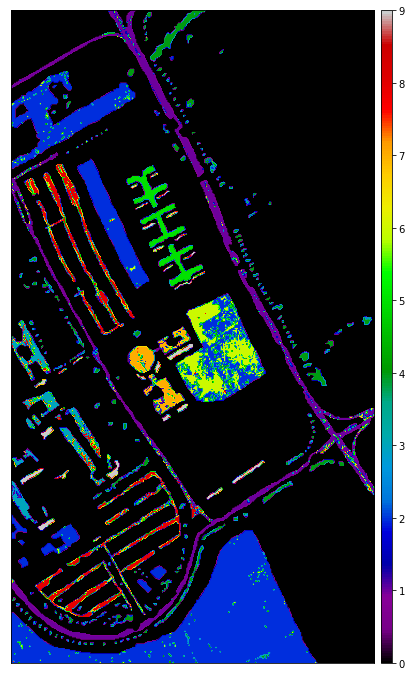

In [ ]:
print(accuracy_score(ae_df['class'].values, pred)*100)
ep.plot_bands(pred.reshape((610, 340)), cmap='nipy_spectral')
plt.show()

In [ ]:
from sklearn.svm import SVC

svm = SVC(C = 5.0, kernel = 'rbf', cache_size = 4*1024)

# Fit Data
svm.fit(X_train, y_train)

# Predict labels for test data
svm_pred = svm.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
print(classification_report(y_test, svm_pred))

Accuracy: 83.7496660432808
              precision    recall  f1-score   support

           1       0.79      0.93      0.85      4642
           2       0.85      0.98      0.91     13055
           3       0.66      0.42      0.52      1469
           4       0.94      0.89      0.91      2145
           5       1.00      0.99      1.00       942
           6       0.89      0.43      0.58      3520
           7       0.81      0.09      0.17       931
           8       0.75      0.88      0.81      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.84     29944
   macro avg       0.85      0.74      0.75     29944
weighted avg       0.84      0.84      0.82     29944




96.68997107039537


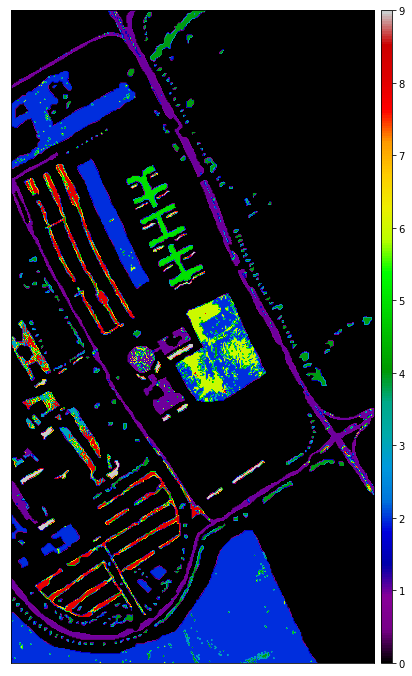

In [ ]:
svm_preds = predict_class(ae_df, svm)
print(accuracy_score(ae_df['class'].values, svm_preds)*100)
ep.plot_bands(svm_preds.reshape((610, 340)), cmap='nipy_spectral')
plt.show()

In [ ]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

# Parameters
params={}
params['learning_rate']=0.08
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=25
params['num_class']=10 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

# prediction
lgb_predictions = clf.predict(X_test)
lgb_pred = np.argmax(lgb_predictions, axis=1)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")
print(classification_report(y_test, lgb_pred))

Accuracy: 88.63211327811915
              precision    recall  f1-score   support

           1       0.92      0.92      0.92      4642
           2       0.90      0.95      0.92     13055
           3       0.76      0.72      0.74      1469
           4       0.94      0.90      0.92      2145
           5       1.00      0.99      0.99       942
           6       0.80      0.66      0.72      3520
           7       0.83      0.77      0.80       931
           8       0.84      0.86      0.85      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.89     29944
   macro avg       0.89      0.86      0.87     29944
weighted avg       0.88      0.89      0.88     29944




98.22950819672131


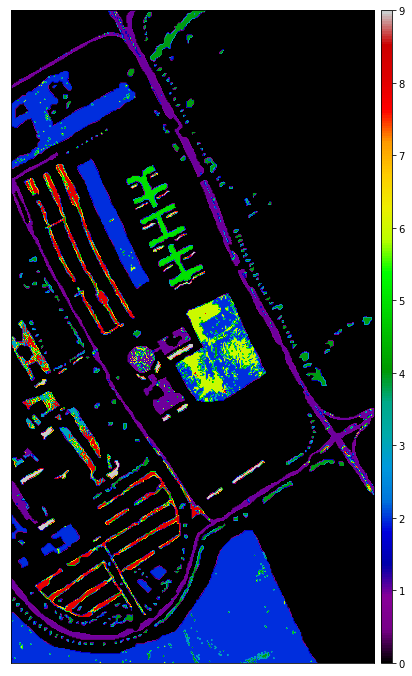

In [ ]:
lgb_preds = predict_class(ae_df, clf, name='lgb')

print(accuracy_score(ae_df['class'].values, lgb_preds)*100)
ep.plot_bands(svm_preds.reshape((610, 340)), cmap='nipy_spectral')
plt.show()